# VISUAL QUESTION ANSWERING : (IMPLEMENTATION IN TENSORFLOW 2.0)

INSPIRATION TAKEN FROM: 
1. [Stacked Attention Network](https://arxiv.org/pdf/1511.02274.pdf)
2. [Stacked Attention Networks for Image Question Answering (Slides)](http://www.cs.virginia.edu/~vicente/vislang/slides/wasimonica.pdf)


### **WHAT DOES THIS NOTEBOOK CONTAINS:**

## This Notebook is divided into three parts:

#### **PART: 1 Question to Embedding**
#### **PART: 2 Loading and Preparaing the dataset for the Model**
#### **PART: 3 Making the Model**


* This notebook does not contain the exact implementation of the Stacked Attention Network, but has been inspired from that paper and the slides that has been mentioned above, and there are drawbacks (because I was unaware of **attention layer** and it's implementation in TensorFlow 2.0, and hence used some simple **Dense** layers in those places)

* This notebook starts from just loading data, which are mentioned as below:
1. **trainset.json**: 

Contains a list of following enteries: 

              * qid
              * image_name
              * image_organ
              * answer
              * answer_type
              * question
              * question_type
              * phrase_type
An example is: {"qid": 1, "image_name": "synpic54610.jpg", "image_organ": "HEAD", "answer": "Yes", "answer_type": "CLOSED", "question_type": "PRES", "question": "Are regions of the brain infarcted?", "phrase_type": "freeform"}

2. **VQA_RAD Image Folder** : This folder contains the images (in .jpg format), whose name are the qid (as mentioned in the trainset.json)

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive



# **PART: 1 Question to Embedding :**

---



---











NOTE: If you are running for the first time, this is an important part to create some important files, but once you have ran it, no need to run in the future sessions

This part of the notebook does the following function:

* Load the **GoogleNews vectors** ([link](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/view?usp=sharing)) (Note if this is your first step, open the link, it will take you to your Google Drive, and then create a copy of the file)

More information about GoogleNews Vectors can be found out [here](https://code.google.com/archive/p/word2vec/)

* Now, having loaded the model, what we need to do is, to create a h5 file, so that dataset can be easily prepared. Each of the h5 file will contain : 1. Question Vector 2. Answer (Label) 

1. Read the question and the answer from **trainset.json**
2. Perform the tokenization on the **questions**, and then convert each of the question into its, corresponding **feature vector** (with the help of **GoogleNews vectors**)
3. Convert the answer into its label (i.e for example yes -> 0, no -> 1, right ->2, etc.)
4. Finally, we have question vector and answer (in label), hence we can store it in a .h5py file format (having the filename as the question id (qid))

The diagram summaraizes all these steps
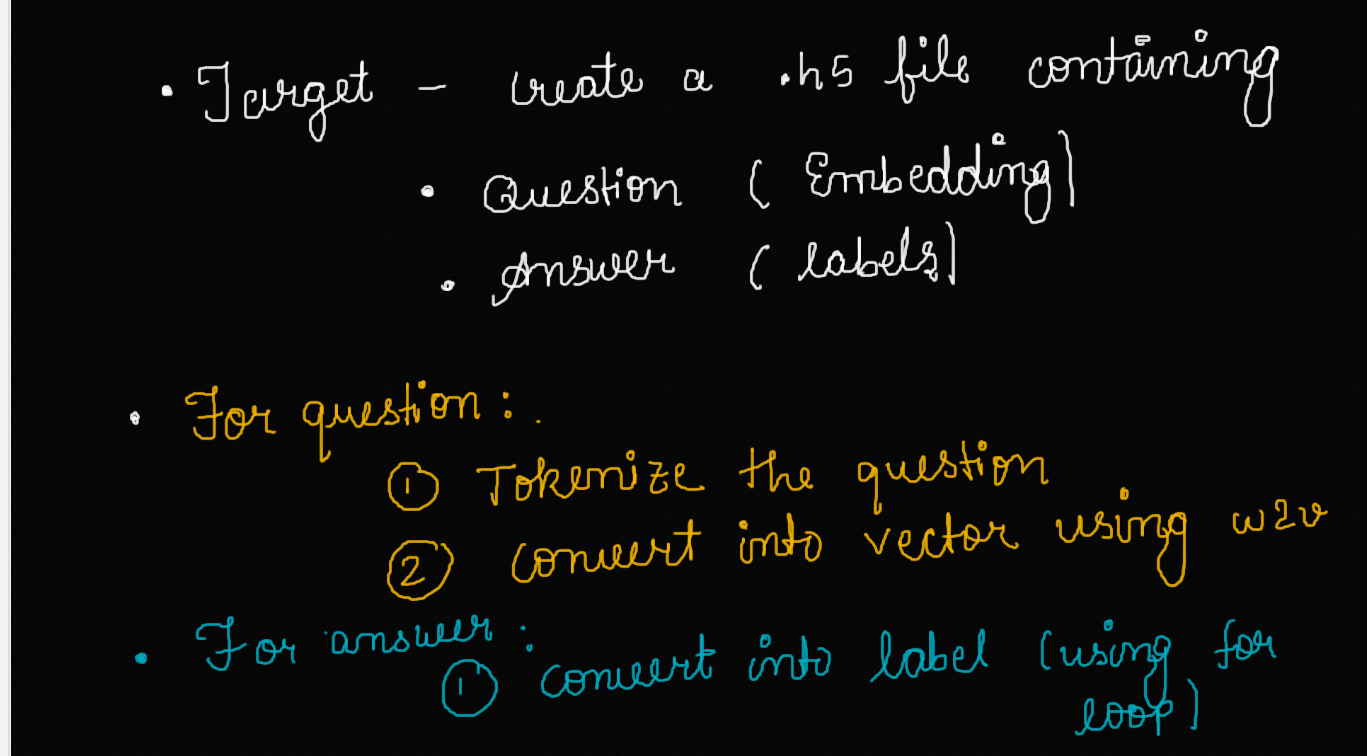


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
model_path = '/content/gdrive/MyDrive/Copy of GoogleNews-vectors-negative300.bin.gz'            # Path where the model is stored
model_w2v = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)            # Loading the model using gensim

In [ ]:
import json
import h5py
import numpy as np
import copy
from random import shuffle, seed
import sys
import os.path
import argparse
import glob
import numpy as np
import scipy.io
import pdb
import string
import h5py
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import gensim
import json
import re
import cv2
import matplotlib.pyplot as plt



def extract_feat(doc):
  '''
    Input: A sentence
    Output : Word Embedding of the sentence 

    Note : In order to maintain uniformity in the word embedding of the question, I have used padding (which would be shown later) with a maximum length of 21 (since this
    is the longest length of the question in trainset.json)
  '''
    feat = []
    for word in doc:
        try:
            feat.append(model_w2v[word])
        except:
            pass
    return feat

def tokenize(sentence):

    ''' Perform Tokenization '''
    return [i for i in re.split(r"([-.\"',:? !\$#@~()*&\^%;\[\]/\\\+<>\n=])", sentence) if i!='' and i!=' ' and i!='\n'];

def prepro_question(imgs, method):
    # preprocess all the question
    print('example processed tokens:')

    '''
    Input: The question from trainset.json
    Performs tokenization and lowering of the question
    Output: Embedded version of the question

    Note that: We have still not padded the questions, just for information each of the word will be a 300 Dimensional Vector,
    hence, the word vector (which will be obtained after padding) will be a (21,300) Dimensional
    '''
    for i,img in enumerate(imgs):
        s = img['question'].lower()
        if method == 'nltk':
            txt = word_tokenize(str(s).lower())
        else:
            txt = tokenize(s)
        img['processed_tokens'] = txt
        if i < 10: print(txt)
        if i % 1000 == 0:
            sys.stdout.write("processing %d/%d (%.2f%% done)   \r" %  (i, len(img), i*100.0/len(imgs)) )
            sys.stdout.flush()   
    return imgs

def get_top_answers(imgs, num_ans):

    """
    Print the questions and returns the time, one answer is repeated
    """
    counts = {}
    for img in imgs:
        try:
            ans = img['answer'].lower()  # If the string is a number, it would result into error
        except :
            ans = str(img['answer'])
        counts[ans] = counts.get(ans, 0) + 1

    cw = sorted([(count,w) for w,count in counts.items()], reverse=True)
    print('top answer and their counts:') 
    print('\n'.join(map(str,cw[:20])))
    
    vocab = []
    for i in range(min(num_ans,len(cw))):
        vocab.append(cw[i][1])

    return vocab[:num_ans]


def filter_question(imgs, atoi):

  ''' Not of much use, I had used it for some other purpose, but did not use it later '''
    new_imgs = []
    for i, img in enumerate(imgs):
            new_imgs.append(img)

    print('question number reduce from %d to %d '%(len(imgs), len(new_imgs)))
    return new_imgs

manualMap = { 'none': '0', 'zero': '0', 'one': '1', 'two': '2', 'three':
                  '3', 'four': '4', 'five': '5', 'six': '6', 'seven': '7',
                  'eight': '8', 'nine': '9', 'ten': '10' }

imgs_train = json.load(open('/content/gdrive/MyDrive/trainset.json' , 'r'))      # Unnnecesarily, i have used the same file two times
num_ans = 1000
top_ans = get_top_answers(imgs_train, num_ans)                         
atoi = {w:i for i,w in enumerate(top_ans)}                   # Word : Count
itoa = {i:w for i,w in enumerate(top_ans)}                   # Count : Word
feat_dim = 300                                               # 300 Dimensional Vector
imgs_data_train = json.load(open('/content/gdrive/MyDrive/trainset.json' , 'r'))  # trainset.json
num_ans = 10    # Even 1 should work fine, but I had taken reference from COCO dataset, and hence, 10 (10 represents the top 10 answers to a picture)
method = 'nltk'
max_length = 21                       # Max Length of the question
dir_path = "/content/gdrive/MyDrive/QA"    # The path where we will be storing .h5 file
N = len(imgs_data_train)

image_path = '/content/gdrive/MyDrive/VQA_RAD Image Folder'

def save_data():
    
 
        for i,img in enumerate(imgs_data_train):
            #print('X' , img['ques_id'])
            img_path = image_path+img['image_name']  

            s = img['question']
            print(i,s)   # Print the number and the question
            if method == 'nltk':
                try:
                    txt = word_tokenize(str(s).lower())
                except :
                    txt = str(s)
            else:
                    txt = tokenize(s)

            img['processed_tokens'] = txt            
            question_id = img['qid']
            feat = np.array(extract_feat(img['processed_tokens']))
            label_arrays = np.zeros((1, max_length, feat_dim), dtype='float32')
            label_length = min(max_length, len(feat)) # record the length of this sequence
            label_arrays[0, :label_length, :] = feat
            try:
                ans_arrays = atoi[img['answer'].lower()]
            except :
                ans_arrays = atoi[str(img['answer'])]

            f = h5py.File(os.path.join( dir_path , str(question_id) + '.h5'), "w")
            f.create_dataset("ques_train", dtype='float32', data=label_arrays)
            f.create_dataset("answers", dtype='uint32', data=ans_arrays)
            f.close()
        return    
 
data = save_data()

725 Is/Are there a subdural hematoma?
726 Is there a subdural hematoma?
727 Is/Are there a subdural hematoma?
728 Approximately how much time was required to obtain this image?
729 Is the heart enlarged?
730 Is/Are the heart enlarged?
731 Is the heart size increased?
732 Is/Are the heart enlarged?
733 Is this a ring enhancing lesion?
734 Is/Are there ring-enhancement?
735 Is there ring-enhancement?
736 Is/Are there ring-enhancement?
737 Are the dark areas grey or white matter?
738 The dark areas of the image show what type of brain matter?
739 What is/are the dark areas near/in the center of the brain?
740 Which ventricles are visible?
741 Is there a fracture?
742 Is/Are there a fracture?
743 Is a fracture present?
744 Is/Are there a fracture?
745 Is this image sufficient for a diagnosis?
746 Is the image enough to diagnose?
747 Would you suspect abcess or cancer for this finding?
748 Is this an abscess or cancer?
749 What are the dark areas at the top of the picture?
750 What is/are t

<a id="t1."></a>
# **PART: 2 Loading and Preparaing the dataset for the Model:**

* So, we have saved each of the question vector and answer vector in a .h5 file
* Now according to [slides](http://www.cs.virginia.edu/~vicente/vislang/slides/wasimonica.pdf), we need to convert the image into a 448 * 448 * 3 images, and then pass it through some preprocessing layers to convert into 14 * 14 * 512 (which will be reshaped to 196 * 512, where each region will be 1 * 1* 512)
* For preprocessing the image, we would use the VGG16 preprocessing layer, which would help in coverting the image to 14 * 14 * 512 dimension ( will be applied while building the model)

In [ ]:
import json
import h5py
import numpy as np
import copy
from random import shuffle, seed
import sys
import os.path
import argparse
import glob
import numpy as np
import scipy.io
import pdb
import string
import h5py
import nltk
from nltk.tokenize import word_tokenize
import gensim
import json
import re
import cv2
import tensorflow as tf
import numpy as np
import keras
import pandas as pd
import os
import matplotlib.pyplot as plt
dropout_rate = 0.4
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# -------------------------------------------------------------------------------------------------------------
# The below part is same as that of part 1

def extract_feat(doc):
    feat = []
    for word in doc:
        try:
            feat.append(model_w2v[word])
        except:
            pass
    return feat

def tokenize(sentence):
    return [i for i in re.split(r"([-.\"',:? !\$#@~()*&\^%;\[\]/\\\+<>\n=])", sentence) if i!='' and i!=' ' and i!='\n'];

def prepro_question(imgs, method):
  
    # preprocess all the question
    print('example processed tokens:')
    for i,img in enumerate(imgs):
        s = img['question'].lower()
        if method == 'nltk':
            txt = word_tokenize(str(s).lower())
        else:
            txt = tokenize(s)
        img['processed_tokens'] = txt
        if i < 10: print(txt)
        if i % 1000 == 0:
            sys.stdout.write("processing %d/%d (%.2f%% done)   \r" %  (i, len(img), i*100.0/len(imgs)) )
            sys.stdout.flush()   
    return imgs

def get_top_answers(imgs, num_ans):
    counts = {}
    for img in imgs:
        try:
            ans = img['answer'].lower() 
        except :
            ans = str(img['answer'])
        counts[ans] = counts.get(ans, 0) + 1 # Frequency count

    cw = sorted([(count,w) for w,count in counts.items()], reverse=True)
    # print('top answer and their counts:') 
    # print('\n'.join(map(str,cw[:20])))
    
    vocab = []
    for i in range(min(num_ans,len(cw))):
        vocab.append(cw[i][1])

    return vocab[:num_ans]


def filter_question(imgs, atoi):
    new_imgs = []
    for i, img in enumerate(imgs):
            new_imgs.append(img)

    print('question number reduce from %d to %d '%(len(imgs), len(new_imgs)))
    return new_imgs
# Old Part finishes
# ---------------------------------------------------------------------------------------------------------------------
# New part starts
# -------------------------------------------------------------------------------------------------------------------
def image_layer(input_shape):
    '''
    Input : Shape of the image
    Output : VGG16 Preprocessing model
    '''
    base_model = tf.keras.applications.VGG16(input_shape=input_shape, include_top=False,weights='imagenet')
    base_model.trainable = False # Do not train it
    x = base_model.layers[-2].output  # Shape would be (28*28*512)
    x = tf.reshape(x , [-1,x.shape[2]*x.shape[1] , x.shape[3]]) # Shape would be (1,784,512)
    x = tf.keras.layers.Dense(1024)                            # This step can be found out in the slides, that after feature extraction, they are connecting a dense layer, slide - 6 (Transform into a same size vector)
    return x

def vgg_preprocessing(model,image):
  ''' Takes a tensor as an input, and returns a pre processed version of the image'''
    return model(image)

def load_data():

        '''
        Input: Nothing

        Output: Returns list containing the following four elements in a tuple
        (preprocessed version of the image,embedded question,embedded answer, question id)
        '''

        images = []
        questions = []
        answers = []
        ids = []
        
        #print(start,end)
        #arrs = np.random.randint(0,len(imgs_data_train),batch)
        #data = [imgs_data_train[i] for i in arrs]
        
        data = imgs_data_train   # trainset.json
        model = image_layer(input_shape = (448,448,3)) # Making VGG16 Model
        for i,img in enumerate(data):
        
            img_path = img['image_name']  # Image Name
            question_id = img['qid']      # Question id

            #label_arrays = np.zeros((1, max_length, feat_dim), dtype='float32') # Somethings are taken directly from 
            
            with h5py.File(os.path.join(dir_path,str(question_id) + '.h5'),'r') as hf:
                question = hf['.']['ques_train'].value # Embedded question
                answer = hf['.']['answers'].value      # Embedded answer
         
            image = cv2.imread(os.path.join('/content/gdrive/MyDrive/VQA_RAD Image Folder',img_path) , cv2.IMREAD_COLOR) # Reading the image
            image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
            image = cv2.resize(image , (448,448)) # Reshape

            '''
            Small Note : I had not applied the VGG Preprocessing here, because I wanted to use the original shape of 448, and then, I would 
            attach the VGG Model, while making the model, I think this makes sense :)
            '''
            #image = vgg_preprocessing(model,image)
            # Apply VGG16 Preprocessings

            images.append(image)
            questions.append(np.array(question))
            answers.append(np.array(answer))
            ids.append(question_id)     
            if i%100==0:
              print("Processed =>",i,' which is',round(100*i/len(data),2),'%')          
        
        questions = np.reshape(np.array(questions) , [-1,max_length,feat_dim])
        return (np.array(images) , questions ,np.array(answers) , np.array(ids))

imgs_train = json.load(open('/content/gdrive/MyDrive/trainset.json' , 'r'))
num_ans = 1000
top_ans = get_top_answers(imgs_train, num_ans )
atoi = {w:i for i,w in enumerate(top_ans)}
itoa = {i:w for i,w in enumerate(top_ans)}
feat_dim = 300
imgs_data_train = json.load(open('/content/gdrive/MyDrive/trainset.json' , 'r'))
num_ans = 10
method = 'nltk'
max_length = 21
dir_path = "/content/gdrive/MyDrive/QA"
N = len(imgs_data_train)

# ---------------------------------------------------------------------------------------
# New part finishes

In [ ]:
import tensorflow as tf
import numpy as np
import keras,h5py
import pandas as pd
import os
import json
from tqdm import tqdm 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from keras.applications.vgg16 import VGG16
import keras.activations
import keras.backend as kbe
from keras.callbacks import EarlyStopping
import tensorflow.keras.layers as layers
from keras.layers import Activation, Add, Concatenate, Conv1D, Dense, Dropout, Embedding, Softmax
from keras.layers import Input, GlobalMaxPooling1D, Lambda, Multiply, RepeatVector, Reshape
from keras.layers import BatchNormalization 
from keras.models import Model
from keras.regularizers import l2
import pickle
from pprint import pprint

''' These parameters are for some of the previous attempts, so ignore it, the main part is : datagen = load_data(), and I don't want to remove all of these,
because indeed there can be some ideas coming out from these lines of code'''

embed_size = 300
q_len = 21
height = 224
width = 224
lstm_units = 256
attention_dim = 512
num_output = 1000
max_questions = 3064

batch_size = 32
lr = 0.001
articles = ['a', 'an', 'the']
manualMap = { 'none': '0', 'zero': '0', 'one': '1', 'two': '2', 'three':
                  '3', 'four': '4', 'five': '5', 'six': '6', 'seven': '7',
                  'eight': '8', 'nine': '9', 'ten': '10' }


datagen = load_data()   # Load the Data

### Creating the Dataset: We do this, by renaming the contents of .h5 file

In [ ]:
images,questions,answers,ids =datagen[0],datagen[1],datagen[2],datagen[3]
print("Images have a size of:",images.shape)
print("Questions have a size of:",questions.shape)
print("Answers have a size of:",answers.shape)
print("Ids have a size of:",ids.shape)
dir_path = r'/content/gdrive/MyDrive/QA' # The directory where the .h5 file for each entry is saved
m = 100
for i in range(images.shape[0]):
    ans_array = answers[i]
    image_array = images[i]
    quest_array = questions[i]
    question_id = ids[i]
    f = h5py.File(os.path.join( dir_path , str(question_id) + '.h5'), "w") # Loading the 'h5 file
    f.create_dataset("ques_train", dtype='float32', data=quest_array) # Question Embedding
    f.create_dataset("image_vector", dtype='float32', data=image_array) # Image Embedding (Not preprocessed)
    f.create_dataset("answers", dtype='uint32', data=ans_array)      # Answers in embedded form
    f.close()
    if i%m ==0:
        print("Processed =>", i,' total percentage =>', round(100*i/images.shape[0],2),' %')
print("Your processing has been done")

# Summary: So, uptil now, in the Part 2, we did the following

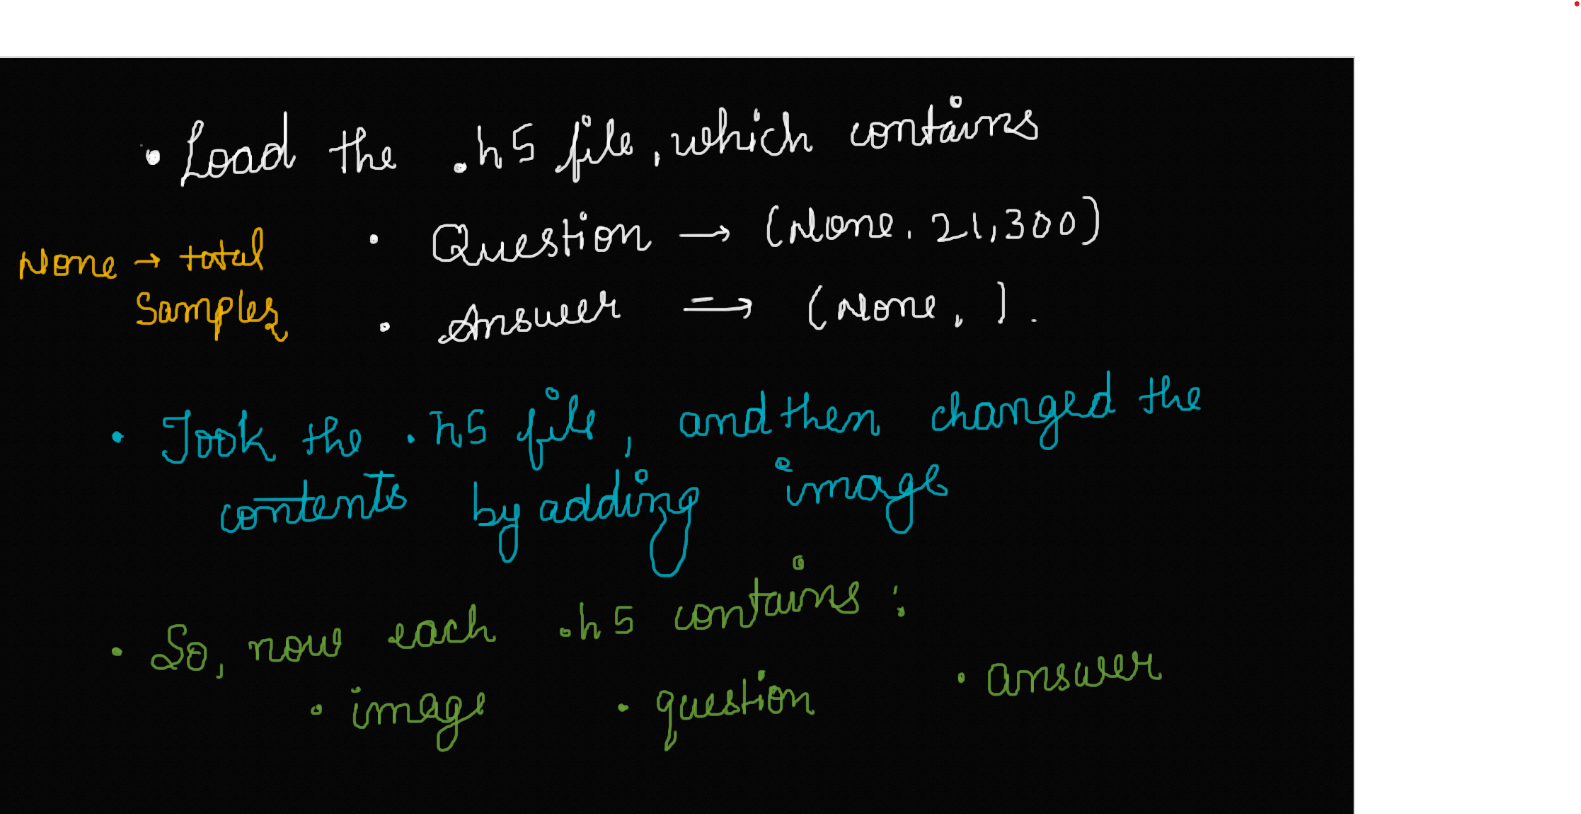

<a id="t2."></a>
# **PART: 3 Making the Model**  ( START RUNNING FROM THIS CELL, IF YOU HAVE ALREADY RAN IT ONCE, AND IS RUNING AGAIN)
So, we go by the following rule:

1. Pre-process the image (making it (None,196,512)), where 196 represents 196 regions, wach of 32 * 32 pixel
2. Make it of the same size of that of question embedding [Slide No. 6](http://www.cs.virginia.edu/~vicente/vislang/slides/wasimonica.pdf)
3. Now, we will pass the ques layer through LSTM, and pass preprocessed image through dense network (activation is tanh), here is the catching point, I had not applied Attention Network as mentioned in the [paper](https://arxiv.org/pdf/1511.02274.pdf), and had seen some implementation of SAN, where they used Dense network with tanh activation, and hence we would do the same
4. Then, we will concatenate both the vectors, and then, pass through dense layers, and final layer with softmax function
5. The loss function is Sparse Categorical Cross Entropy, optimizer is Adam with learning rate of 0.01, and batch size of 32, and for 50 epochs

In [2]:
# link - http://www.cs.virginia.edu/~vicente/vislang/slides/wasimonica.pdf
import os,h5py
# Image Model
import tensorflow as tf
import numpy as np
from tensorflow.keras import Model
import warnings
warnings.filterwarnings('ignore')

'''  Preprocessing with the VGG 16 Model  '''

model = tf.keras.applications.VGG16(include_top=False,weights='imagenet',
        input_shape=(448,448,3))
#print("The Last layer")
last_layer = model.layers[-1].output   # Last layer has an output layer of (14,14,512)
model = Model(model.input,last_layer)
model.trainable = False
# print(model.summary())
def extract_feature(image):
    ''' Preprocessing with VGG Netowrk'''
    image = model(image)
    return image  # Shape is (196,512)

'''  The below model will convert (196,512) to (21,300) (i.e same as the dimension of word embedding)  '''

dimen_red = tf.keras.Sequential()  # Use for converting (196,512) -> (21,300)
dimen_red.add(tf.keras.layers.Conv2D(300,kernel_size=(1,1),input_shape= (14,14,512)))
dimen_red.add(tf.keras.layers.Reshape((196,300)))
dimen_red.add(tf.keras.layers.Permute((2,1)))  # Reshaping about the axis, useful for applying the dense network
dimen_red.add(tf.keras.layers.Dense(21))
dimen_red.add(tf.keras.layers.Permute((2,1)))  # Reshaping about the axis, useful for applying the dense network

train_dir = r'drive/MyDrive/QA/' # Containing .h5 file
images = []
ans = []
ques = []
count = 0
content = os.listdir(train_dir)[:2300]   # The GPU Memory became full after this, hence had to take just these much samples :(
length = len(content)
for i in content:
    # Reading the data
    file = h5py.File(train_dir+i)
    images.append(np.array(file['.']['image_vector'].value))
    ans.append(np.array(file['.']['answers'].value))
    ques.append(np.array(file['.']['ques_train'].value))
    count+=1
    if count%100 == 0:
      print("The count is:",count,"and the percentage proportion is:",round(100*count/length,2),'%')
images = tf.convert_to_tensor(np.array(images))   # For the GPU purpose
ans = tf.convert_to_tensor(np.array(ans))
ques = tf.convert_to_tensor(np.array(ques))

58892288/58889256 [==============================] - 1s 0us/step
The count is: 100 and the percentage proportion is: 4.35 %
The count is: 200 and the percentage proportion is: 8.7 %
The count is: 300 and the percentage proportion is: 13.04 %
The count is: 400 and the percentage proportion is: 17.39 %
The count is: 500 and the percentage proportion is: 21.74 %
The count is: 600 and the percentage proportion is: 26.09 %
The count is: 700 and the percentage proportion is: 30.43 %
The count is: 800 and the percentage proportion is: 34.78 %
The count is: 900 and the percentage proportion is: 39.13 %
The count is: 1000 and the percentage proportion is: 43.48 %
The count is: 1100 and the percentage proportion is: 47.83 %
The count is: 1200 and the percentage proportion is: 52.17 %
The count is: 1300 and the percentage proportion is: 56.52 %
The count is: 1400 and the percentage proportion is: 60.87 %
The count is: 1500 and the percentage proportion is: 65.22 %
The count is: 1600 and the perce

In [3]:
l = []
length = images.shape[0]
for i,j in enumerate(images):
  l.append(model(tf.reshape(j,[1,448,448,3])))  # It was not possible directly on GPU, hence had to use for loop
  if i%100 ==0:
    print("The count is:",i,"and the percentage proportion is:",round(100*i/length,2),'%')
images = tf.convert_to_tensor(np.array(l) )

The count is: 0 and the percentage proportion is: 0.0 %
The count is: 100 and the percentage proportion is: 4.35 %
The count is: 200 and the percentage proportion is: 8.7 %
The count is: 300 and the percentage proportion is: 13.04 %
The count is: 400 and the percentage proportion is: 17.39 %
The count is: 500 and the percentage proportion is: 21.74 %
The count is: 600 and the percentage proportion is: 26.09 %
The count is: 700 and the percentage proportion is: 30.43 %
The count is: 800 and the percentage proportion is: 34.78 %
The count is: 900 and the percentage proportion is: 39.13 %
The count is: 1000 and the percentage proportion is: 43.48 %
The count is: 1100 and the percentage proportion is: 47.83 %
The count is: 1200 and the percentage proportion is: 52.17 %
The count is: 1300 and the percentage proportion is: 56.52 %
The count is: 1400 and the percentage proportion is: 60.87 %
The count is: 1500 and the percentage proportion is: 65.22 %
The count is: 1600 and the percentage pro

In [4]:
l = []
length = images.shape[0]
for i,j in enumerate(images):
  l.append(dimen_red(j))     # Making it to the same shape as that of question embedding
  if i%100 ==0:
    print("The count is:",i,"and the percentage proportion is:",round(100*i/length,2),'%')
images = tf.convert_to_tensor(np.array(l))

The count is: 0 and the percentage proportion is: 0.0 %
The count is: 100 and the percentage proportion is: 4.35 %
The count is: 200 and the percentage proportion is: 8.7 %
The count is: 300 and the percentage proportion is: 13.04 %
The count is: 400 and the percentage proportion is: 17.39 %
The count is: 500 and the percentage proportion is: 21.74 %
The count is: 600 and the percentage proportion is: 26.09 %
The count is: 700 and the percentage proportion is: 30.43 %
The count is: 800 and the percentage proportion is: 34.78 %
The count is: 900 and the percentage proportion is: 39.13 %
The count is: 1000 and the percentage proportion is: 43.48 %
The count is: 1100 and the percentage proportion is: 47.83 %
The count is: 1200 and the percentage proportion is: 52.17 %
The count is: 1300 and the percentage proportion is: 56.52 %
The count is: 1400 and the percentage proportion is: 60.87 %
The count is: 1500 and the percentage proportion is: 65.22 %
The count is: 1600 and the percentage pro

In [5]:
images = tf.reshape(images,[length,21,300])
img = images  #Tensor containing images
que = ques  # Tensor containing question vector
img = img/255.0 # Normalizing

In [6]:
que.shape,img.shape

(TensorShape([2300, 21, 300]), TensorShape([2300, 21, 300]))

In [7]:
''' The below mentioned two Input objects of keras will be useful for making the model '''

ques = tf.keras.layers.Input((21,300))  # Input Model (for ques)
images = tf.keras.layers.Input((21,300)) # Input Model (for images)

## Note: I had not applied Attention Network as mentioned in the [paper](https://arxiv.org/pdf/1511.02274.pdf), and had seen some implementation of SAN, where they used Dense network with tanh activation, and hence we would do the same

In [8]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D,Flatten,Concatenate

''' Imagica is for the preprocessing of the image part'''
imagica = Dense(512,activation='tanh')(images)
imagica = Dense(512,activation='tanh')(images)


''' quesa is for the ques layer, which means preprocessing of the question layer'''
quesa = LSTM(512, dropout = 0.3,return_sequences = True,input_shape = (21,300))(ques)
quesa = Dense(512, activation = 'relu')(quesa)
quesa = Dropout(0.3)(quesa)
quesa = Dense(512, activation = 'relu')(quesa)
quesa = Dropout(0.3)(quesa)

''' Concatenating both image and the question layer'''
quesa = Concatenate()([quesa,imagica])
quesa = Flatten()(quesa)
out = tf.keras.layers.Dense(476,activation='softmax')(quesa) # Final output has 476 different categories, you can check by finding length of uniquue answers :)

## Plotting the Model

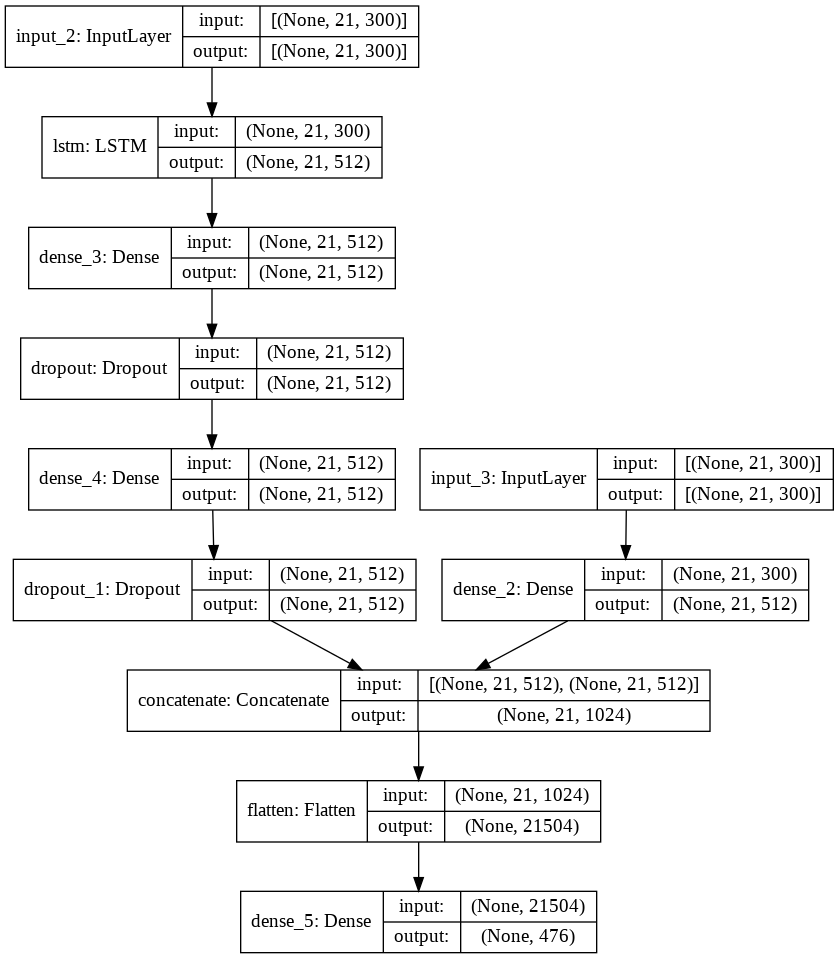

In [9]:
from keras.utils.vis_utils import plot_model
model = Model([ques,images],[out])
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Compiling and fitting the model

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01),loss ='sparse_categorical_crossentropy',metrics=['accuracy'])

In [11]:
answers = tf.keras.utils.to_categorical(ans)
answers.shape

(2300, 476)

In [12]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 21, 300)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 21, 512)      1665024     input_2[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 21, 512)      262656      lstm[0][0]                       
__________________________________________________________________________________________________
dropout (Dropout)               (None, 21, 512)      0           dense_3[0][0]                    
____________________________________________________________________________________________

In [13]:
model.fit([img,que],ans,epochs = 50,batch_size=32,verbose=1)

Epoch 1/50
72/72 [==============================] - 3s 12ms/step - loss: 10.4432 - accuracy: 0.2943
Epoch 2/50
72/72 [==============================] - 1s 11ms/step - loss: 2.1402 - accuracy: 0.6094
Epoch 3/50
72/72 [==============================] - 1s 11ms/step - loss: 2.9801 - accuracy: 0.6277
Epoch 4/50
72/72 [==============================] - 1s 11ms/step - loss: 3.3520 - accuracy: 0.6549
Epoch 5/50
72/72 [==============================] - 1s 11ms/step - loss: 3.8808 - accuracy: 0.6729
Epoch 6/50
72/72 [==============================] - 1s 11ms/step - loss: 3.9790 - accuracy: 0.7060
Epoch 7/50
72/72 [==============================] - 1s 11ms/step - loss: 4.7241 - accuracy: 0.7324
Epoch 8/50
72/72 [==============================] - 1s 11ms/step - loss: 3.8976 - accuracy: 0.7389
Epoch 9/50
72/72 [==============================] - 1s 11ms/step - loss: 4.6822 - accuracy: 0.7731
Epoch 10/50
72/72 [==============================] - 1s 11ms/step - loss: 4.4351 - accuracy: 0.7760
Epoch 11

## Saving the Model and analysing the prediction

In [14]:
model.save('/content/drive/MyDrive/VQA_Model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/VQA_Model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/VQA_Model/assets


In [15]:
prediction = tf.argmax(model.predict([img,que]),axis=1).numpy()

In [16]:
import json
x = open('/content/drive/MyDrive/trainset.json','r')
train = json.load(x)
train[0]

{'answer': 'Yes',
 'answer_type': 'CLOSED',
 'image_name': 'synpic54610.jpg',
 'image_organ': 'HEAD',
 'phrase_type': 'freeform',
 'qid': 1,
 'question': 'Are regions of the brain infarcted?',
 'question_type': 'PRES'}

## Results

The Question is: Is/Are there a Pleural effusion?
The answer is: Actual: No predicted value: yes
**************************************************


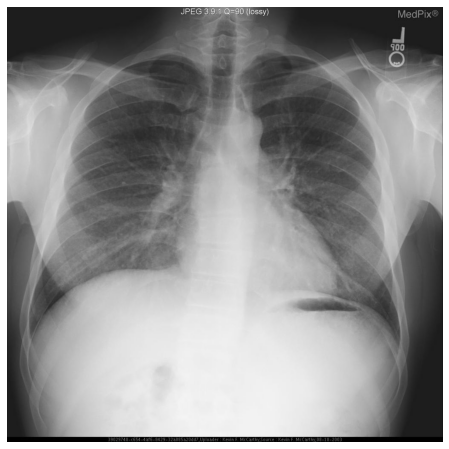

The Question is: Is a pleural effusion present?
The answer is: Actual: No predicted value: yes
**************************************************


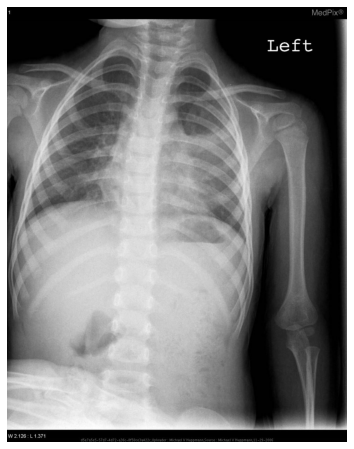

The Question is: Is there a pleural effusion?
The answer is: Actual: No predicted value: no
**************************************************


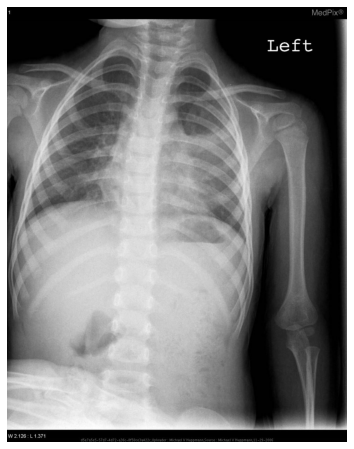

The Question is: Is the heart size abnormal?
The answer is: Actual: No predicted value: no
**************************************************


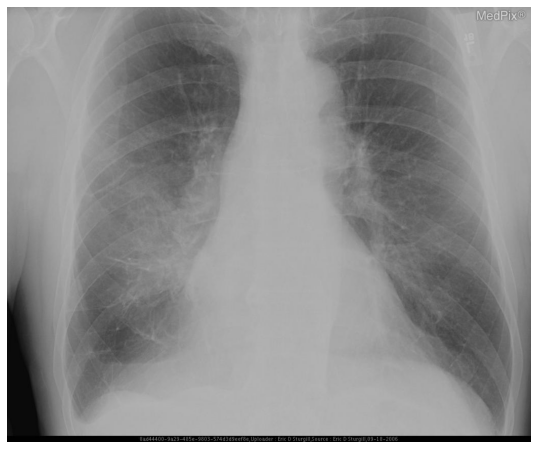

The Question is: Is the heart enlarged?
The answer is: Actual: No predicted value: no
**************************************************


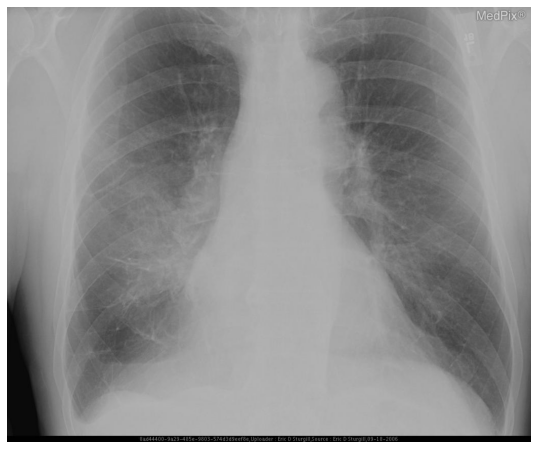

In [21]:
import pickle
x = open('/content/drive/MyDrive/cache/trainval_label2ans.pkl','rb')
a2lab = pickle.load(x)
import cv2
img_path = '/content/drive/MyDrive/VQA_RAD Image Folder/'
import matplotlib.pyplot as plt
%matplotlib inline
for i in range(760,770,2):
  plt.figure(figsize=(10,8))
  image = cv2.imread(img_path+ train[i]['image_name'])
  plt.imshow(image)
  value = "Actual: "+str(train[i]['answer'])+' predicted value: '+ str(a2lab[prediction[i]])
  plt.axis('off')
  print("The Question is:",train[i]['question'])
  print("The answer is:",value)
  print("*"*50)
  plt.show()

## END OF THE NOTEBOOK :)